# Classificação dos fungos Pós-processamento (Depois da manipulação das imagens)

In [1]:

import os
import cv2
import numpy as np
from skimage.feature import hog
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import time


In [2]:
Dataset_path = "../defungi_dataset_processed"
Image_size = (64, 128)
HOG_orientation = 9
HOG_pixels_per_cell = (8, 8)
HoG_cells_per_block = (2, 2)


In [3]:
# extrair dados

data = []
labels = []

classes_names = [d for d in os.listdir(Dataset_path) if os.path.isdir(os.path.join(Dataset_path, d))]
label_mapping = {name: i for i, name in enumerate(classes_names)}

for nome_classe,label_id in label_mapping.items():
    class_path = os.path.join(Dataset_path, nome_classe)
    for nome_imagem in os.listdir(class_path):
        image_path = os.path.join(class_path,nome_imagem)
        image = cv2.imread(image_path)
        if image is None:
            print(f"Erro ao carregar a imagem: {image_path}")
            continue

        resized_image = cv2.resize(image, Image_size)
        gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
        data.append(gray_image)
        labels.append(label_id)



In [4]:
# transformar as imagens em HOG features
hog_features = []
for image in data:
    features = hog(image, 
                   orientations=HOG_orientation, 
                   pixels_per_cell=HOG_pixels_per_cell, 
                   cells_per_block=HoG_cells_per_block, 
                   block_norm='L2-Hys', 
                   visualize=False)
    hog_features.append(features)


In [5]:
X = np.array(hog_features)
y = np.array(labels)

# Dividir o dataset em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

print(f"Total de imagens: {len(data)}")
print(f"Total de classes: {len(classes_names)}")
print(f"Total de imagens de treino: {len(X_train)}")
print(f"Total de imagens de teste: {len(X_test)}")


Total de imagens: 9114
Total de classes: 5
Total de imagens de treino: 7291
Total de imagens de teste: 1823


# SVM

In [18]:
model = SVC(kernel='linear', probability=True,C=1.0, random_state=42)
model.fit(X_train, y_train)
print("Modelo treinado com sucesso!")
y_pred = model.predict(X_test)


Modelo treinado com sucesso!


In [19]:
accuracy = accuracy_score(y_test, y_pred)
print("\n--- RESULTADOS DA AVALIAÇÃO ---")
print(f"Acurácia do modelo: {accuracy:.2%}")
print("\nRelatório de Classificação:")
    
# Inverte o mapa de rótulos para mostrar os nomes das classes no relatório
target_names = [name for name, i in sorted(label_mapping.items(), key=lambda item: item[1])]
print(classification_report(y_test, y_pred, target_names=target_names))


--- RESULTADOS DA AVALIAÇÃO ---
Acurácia do modelo: 46.74%

Relatório de Classificação:
              precision    recall  f1-score   support

         TSH       0.61      0.68      0.64       884
        BASH       0.35      0.27      0.30       486
         GMA       0.19      0.21      0.20       155
         SHC       0.32      0.34      0.33       157
         BBH       0.28      0.23      0.25       141

    accuracy                           0.47      1823
   macro avg       0.35      0.35      0.34      1823
weighted avg       0.45      0.47      0.46      1823



# Matriz de confusão

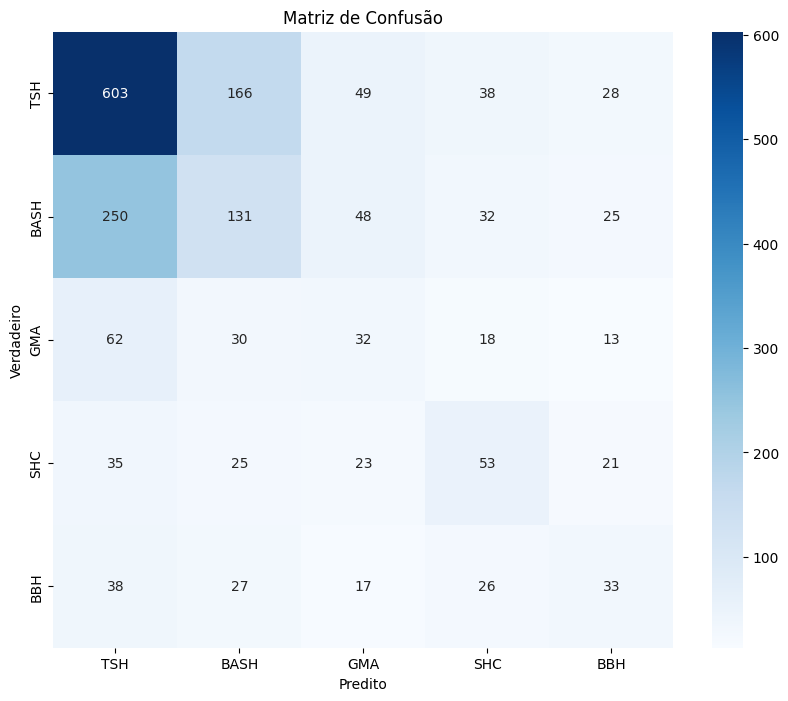

In [20]:
# matriz de confusão
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title('Matriz de Confusão')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.show()

# Como ficaram as 10 primeiras e 10 últimas imagens de cada pasta


Primeiras 10 imagens da pasta 'TSH':


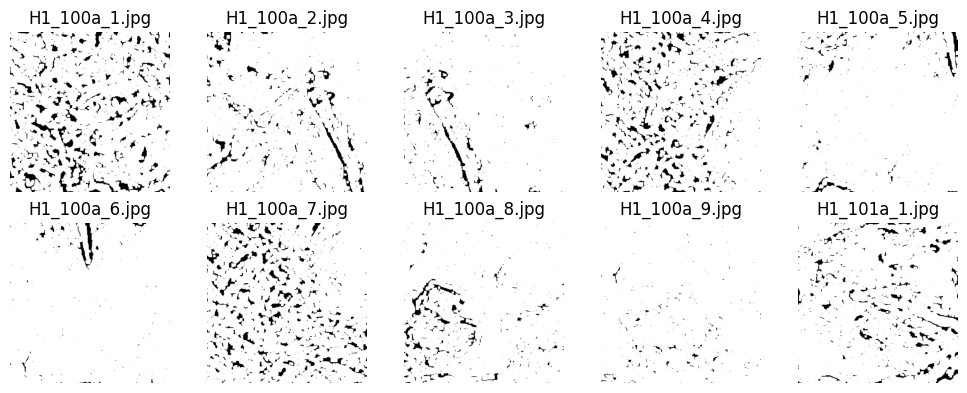

In [24]:
# Primeira pasta
first_class = classes_names[0]
first_class_path = os.path.join(Dataset_path, first_class)
first_class_images = os.listdir(first_class_path)[:10]
print(f"\nPrimeiras 10 imagens da pasta '{first_class}':")

# Carregar as imagens
images = []
for img_name in first_class_images:
    img_path = os.path.join(first_class_path, img_name)
    img = cv2.imread(img_path)
    if img is not None:
        images.append(img)

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 2, nrows * 2))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < len(images):
        img_rgb = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)  # BGR → RGB para mostrar corretamente
        ax.imshow(img_rgb)
        ax.set_title(first_class_images[i])
    ax.axis("off")

plt.tight_layout()
plt.show()


Primeiras 10 imagens da pasta 'BASH':


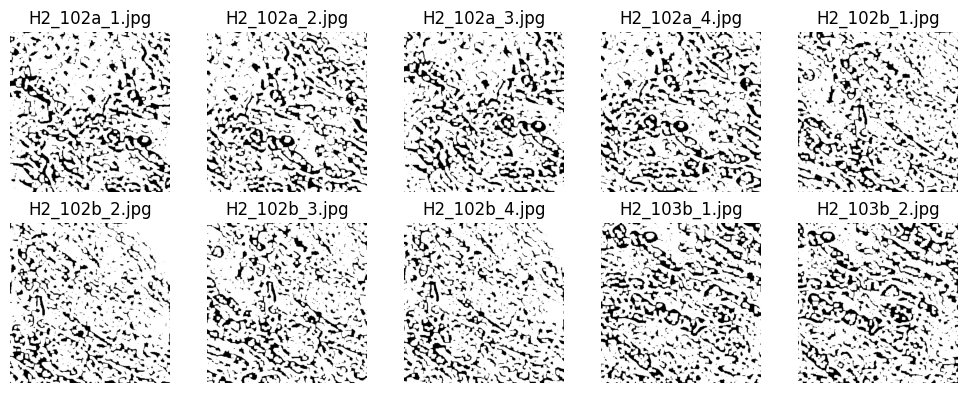

In [23]:
#Segunda pasta
second_class = classes_names[1]
second_class_path = os.path.join(Dataset_path, second_class)
second_class_images = os.listdir(second_class_path)[:10]
print(f"\nPrimeiras 10 imagens da pasta '{second_class}':")

# Carregar as imagens
images = []
for img_name in second_class_images:
    img_path = os.path.join(second_class_path, img_name)
    img = cv2.imread(img_path)
    if img is not None:
        images.append(img)

nrows, ncols = 2, 5  # 2 linhas, 5 colunas para 10 imagens
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 2, nrows * 2))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < len(images):
        img_rgb = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
        ax.imshow(img_rgb)
        ax.set_title(second_class_images[i])
    ax.axis("off")

plt.tight_layout()
plt.show()

# KNN

In [7]:
model_knn = KNeighborsClassifier()

# Busca por hiperparâmetros (número de vizinhos) usando GridSearchCV
param_grid = {'n_neighbors': [5]}  # Testando diferentes valores de k
grid_search = GridSearchCV(model_knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Obtendo o melhor modelo
model_knn = grid_search.best_estimator_
print(f"Modelo KNN treinado com sucesso! Melhor número de vizinhos: {grid_search.best_params_['n_neighbors']}")

# Avaliação com validação cruzada
cv_scores = cross_val_score(model_knn, X_train, y_train, cv=5, scoring='accuracy')
print(f"\nAcurácia média na validação cruzada (5-fold): {np.mean(cv_scores):.2%} ± {np.std(cv_scores):.2%}")

# Previsões no conjunto de teste
y_knn_pred = model_knn.predict(X_test)

Modelo KNN treinado com sucesso! Melhor número de vizinhos: 5

Acurácia média na validação cruzada (5-fold): 31.93% ± 1.15%


In [9]:
accuracy = accuracy_score(y_test, y_knn_pred)
print("\n--- RESULTADOS DA AVALIAÇÃO ---")
print(f"Acurácia do modelo: {accuracy:.2%}")
print("\nRelatório de Classificação:")
    
# Inverte o mapa de rótulos para mostrar os nomes das classes no relatório
target_names = [name for name, i in sorted(label_mapping.items(), key=lambda item: item[1])]
print(classification_report(y_test, y_knn_pred, target_names=target_names))


--- RESULTADOS DA AVALIAÇÃO ---
Acurácia do modelo: 33.57%

Relatório de Classificação:
              precision    recall  f1-score   support

         TSH       0.66      0.41      0.51       884
        BASH       0.27      0.20      0.23       486
         GMA       0.08      0.09      0.09       155
         SHC       0.21      0.71      0.32       157
         BBH       0.12      0.18      0.14       141

    accuracy                           0.34      1823
   macro avg       0.27      0.32      0.26      1823
weighted avg       0.43      0.34      0.35      1823



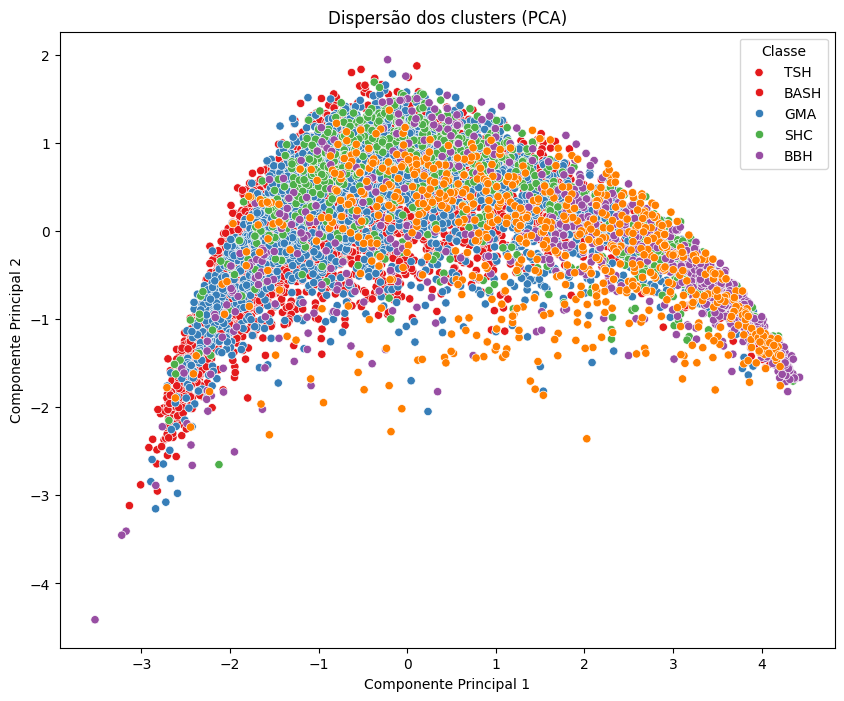

In [10]:
from sklearn.decomposition import PCA

# Visualização da dispersão dos clusters usando PCA para reduzir a dimensionalidade

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='Set1', legend='full')
plt.title('Dispersão dos clusters (PCA)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Classe', labels=target_names)
plt.show()

# CNN

In [49]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [50]:
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    # Compilando o modelo
    model.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    return model

In [51]:
deep_data = []

classes_names = [d for d in os.listdir(Dataset_path) if os.path.isdir(os.path.join(Dataset_path, d))]
label_mapping = {name: i for i, name in enumerate(classes_names)}

for nome_classe, label_id in label_mapping.items():
    class_path = os.path.join(Dataset_path, nome_classe)
    for nome_imagem in os.listdir(class_path):
        image_path = os.path.join(class_path, nome_imagem)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            print(f"Erro ao carregar a imagem: {image_path}")
            continue

        img_resized = cv2.resize(image, (28, 28))
        img_final = img_resized.reshape((28, 28, 1))  # formato (altura, largura, canais)
        deep_data.append(img_final)


In [52]:
# Converter deep_data e labels para numpy arrays
deep_data_np = np.array(deep_data)
labels_np = np.array(labels)

# Dividir o dataset em treino e teste para CNN
deep_X_train, deep_X_test, deep_y_train, deep_y_test = train_test_split(
    deep_data_np, labels_np, test_size=0.2, random_state=42
)

print(f"Formato X_train: {deep_X_train.shape}")
print(f"Formato X_test: {deep_X_test.shape}")
print(f"Formato y_train: {deep_y_train.shape}")
print(f"Formato y_test: {deep_y_test.shape}")

Formato X_train: (7291, 28, 28, 1)
Formato X_test: (1823, 28, 28, 1)
Formato y_train: (7291,)
Formato y_test: (1823,)


In [53]:
# Supondo que X_train e X_test estão no formato (amostras, altura, largura, canais)
# Exemplo: para imagens 28x28 em escala de cinza, input_shape=(28, 28, 1)
input_shape = (28, 28, 1)  # Ajuste conforme o formato das suas imagens
num_classes = len(np.unique(deep_y_train))  # Número de classes baseado em y_train

# Criando o modelo
model = create_cnn_model(input_shape, num_classes)

# Treinando o modelo
model.fit(deep_X_train, deep_y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

print("Modelo treinado com sucesso!")

# Fazendo previsões
y_pred_prob = model.predict(deep_X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

Epoch 1/50


/home/luiz/.pyenv/versions/temfungai310/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.3959 - loss: 4.5737 - val_accuracy: 0.4503 - val_loss: 1.2874
Epoch 2/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4953 - loss: 1.2651 - val_accuracy: 0.5182 - val_loss: 1.2384
Epoch 3/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5397 - loss: 1.1843 - val_accuracy: 0.5065 - val_loss: 1.2139
Epoch 4/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5261 - loss: 1.2103 - val_accuracy: 0.5195 - val_loss: 1.2253
Epoch 5/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5277 - loss: 1.2069 - val_accuracy: 0.5093 - val_loss: 1.1900
Epoch 6/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5269 - loss: 1.1903 - val_accuracy: 0.5093 - val_loss: 1.2186
Epoch 7/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5310 - loss: 1.1896 - val_accuracy: 0.5113 - val_loss: 1.1995
Epoch 8/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5321 - loss: 1.1775 - val_accuracy: 0.5195 - val

In [54]:
# Avaliação
accuracy = accuracy_score(deep_y_test, y_pred)
print("\n--- RESULTADOS DA AVALIAÇÃO ---")
print(f"Acurácia do modelo: {accuracy:.2%}")
print("\nRelatório de Classificação:")

# Inverte o mapa de rótulos para mostrar os nomes das classes no relatório
target_names = [name for name, i in sorted(label_mapping.items(), key=lambda item: item[1])]
print(classification_report(y_test, y_pred, target_names=target_names))


--- RESULTADOS DA AVALIAÇÃO ---
Acurácia do modelo: 46.46%

Relatório de Classificação:
              precision    recall  f1-score   support

         TSH       0.60      0.71      0.65       884
        BASH       0.29      0.22      0.25       486
         GMA       0.17      0.14      0.15       155
         SHC       0.41      0.36      0.38       157
         BBH       0.21      0.23      0.22       141

    accuracy                           0.46      1823
   macro avg       0.34      0.33      0.33      1823
weighted avg       0.44      0.46      0.45      1823



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
Classe prevista: TSH
Classe real: GMA
Resultado: ERROU


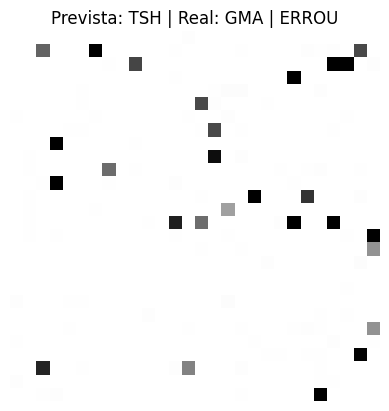

In [55]:
# Seleciona uma imagem do conjunto de teste (por exemplo, a primeira)
test_img = deep_X_test[536]

# Adiciona uma dimensão extra para batch (necessário para o modelo Keras)
test_img_batch = np.expand_dims(test_img, axis=0)

# Faz a predição
pred_prob = model.predict(test_img_batch)
pred_class = np.argmax(pred_prob, axis=1)[0]

# Classe real
real_class = deep_y_test[536]

# Verifica se acertou
acertou = pred_class == real_class
resultado = "ACERTOU" if acertou else "ERROU"

print(f"Classe prevista: {target_names[pred_class]}")
print(f"Classe real: {target_names[real_class]}")
print(f"Resultado: {resultado}")

plt.imshow(test_img.squeeze(), cmap='gray')
plt.title(f"Prevista: {target_names[pred_class]} | Real: {target_names[real_class]} | {resultado}")
plt.axis('off')
plt.show()

# CNN

In [60]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [61]:
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(256, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(512, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [62]:
# Configurar ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.1
)

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)

In [63]:
# Carregar dados
train_generator = train_datagen.flow_from_directory(
    Dataset_path,
    target_size=(128, 128),
    color_mode='grayscale',
    batch_size=32,
    class_mode='sparse',
    subset='training'
)

val_generator = val_datagen.flow_from_directory(
    Dataset_path,
    target_size=(128, 128),
    color_mode='grayscale',
    batch_size=32,
    class_mode='sparse',
    subset='validation'
)


Found 8206 images belonging to 5 classes.


Found 908 images belonging to 5 classes.


In [64]:
# Criar e treinar o modelo
input_shape = (128, 128, 1)
num_classes = len(train_generator.class_indices)
model = create_cnn_model(input_shape, num_classes)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=50,
    validation_data=val_generator,
    validation_steps=val_generator.samples // 32,
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

print("Modelo treinado com sucesso!")

Epoch 1/50


/home/luiz/.pyenv/versions/temfungai310/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/luiz/.pyenv/versions/temfungai310/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2025-07-24 02:04:06.825277: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 662.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-07-24 02:04:06.855367: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 662.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.3974 - loss: 2.4194

2025-07-24 02:04:24.989219: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_189_0', 44 bytes spill stores, 44 bytes spill loads

2025-07-24 02:04:25.369446: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_189', 484 bytes spill stores, 484 bytes spill loads

2025-07-24 02:04:25.548851: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 662.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


256/256 ━━━━━━━━━━━━━━━━━━━━ 23s 69ms/step - accuracy: 0.3975 - loss: 2.4170 - val_accuracy: 0.4844 - val_loss: 1.2992
Epoch 2/50
  1/256 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5000 - loss: 1.2805

/home/luiz/.pyenv/versions/temfungai310/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5000 - loss: 1.2805 - val_accuracy: 0.4844 - val_loss: 1.3018
Epoch 3/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.4727 - loss: 1.3162 - val_accuracy: 0.4833 - val_loss: 1.1703
Epoch 4/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3750 - loss: 1.4796 - val_accuracy: 0.4810 - val_loss: 1.1735
Epoch 5/50
255/256 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4964 - loss: 1.2464

256/256 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.4965 - loss: 1.2465 - val_accuracy: 0.5212 - val_loss: 1.1445
Epoch 6/50
  1/256 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4375 - loss: 1.2255

256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4375 - loss: 1.2255 - val_accuracy: 0.5223 - val_loss: 1.1460
Epoch 7/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.5110 - loss: 1.2082 - val_accuracy: 0.5179 - val_loss: 1.1508
Epoch 8/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5312 - loss: 1.3647 - val_accuracy: 0.5134 - val_loss: 1.1558
Epoch 9/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.5176 - loss: 1.1979 - val_accuracy: 0.5089 - val_loss: 1.1949
Epoch 10/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5312 - loss: 1.1357 - val_accuracy: 0.5112 - val_loss: 1.1920
Epoch 11/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.5236 - loss: 1.1867 - val_accuracy: 0.5123 - val_loss: 1.1860
Epoch 12/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5312 - loss: 1.2022 - val_accuracy: 0.5201 - val_loss: 1.1938
Epoch 13/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5220 - loss: 1.1858

256/256 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.5220 - loss: 1.1858 - val_accuracy: 0.5379 - val_loss: 1.3389
Epoch 14/50
  1/256 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4688 - loss: 1.4691

256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4688 - loss: 1.4691 - val_accuracy: 0.5402 - val_loss: 1.3186
Epoch 15/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.5298 - loss: 1.1814 - val_accuracy: 0.5368 - val_loss: 1.1892
Modelo treinado com sucesso!


In [65]:
# Avaliação no conjunto de teste
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    Dataset_path,
    target_size=(128, 128),
    color_mode='grayscale',
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test = test_generator.classes

Found 9114 images belonging to 5 classes.


282/285 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

2025-07-24 02:06:05.221451: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_174_0', 36 bytes spill stores, 36 bytes spill loads

2025-07-24 02:06:05.319833: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_181', 4 bytes spill stores, 4 bytes spill loads

2025-07-24 02:06:05.344971: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_174', 488 bytes spill stores, 488 bytes spill loads

2025-07-24 02:06:05.577856: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 642.88MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance g

285/285 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step


In [66]:
# Resultados
accuracy = accuracy_score(y_test, y_pred)
print("\n--- RESULTADOS DA AVALIAÇÃO ---")
print(f"Acurácia do modelo: {accuracy:.2%}")

# Relatório de classificação
target_names = list(train_generator.class_indices.keys())
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=target_names))



--- RESULTADOS DA AVALIAÇÃO ---
Acurácia do modelo: 51.08%

Relatório de Classificação:
              precision    recall  f1-score   support

        BASH       0.00      0.00      0.00      2334
         BBH       0.00      0.00      0.00       739
         GMA       0.00      0.00      0.00       819
         SHC       0.59      0.32      0.42       818
         TSH       0.51      1.00      0.67      4404

    accuracy                           0.51      9114
   macro avg       0.22      0.26      0.22      9114
weighted avg       0.30      0.51      0.36      9114



/home/luiz/.pyenv/versions/temfungai310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/luiz/.pyenv/versions/temfungai310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/luiz/.pyenv/versions/temfungai310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifi

In [68]:
# Seleciona uma imagem do conjunto de teste (por exemplo, a primeira)
test_img = deep_X_test[536]

# Adiciona uma dimensão extra para batch (necessário para o modelo Keras)
test_img_batch = np.expand_dims(test_img, axis=0)

# Faz a predição
pred_prob = model.predict(test_img_batch)
pred_class = np.argmax(pred_prob, axis=1)[0]

# Classe real
real_class = deep_y_test[536]

# Verifica se acertou
acertou = pred_class == real_class
resultado = "ACERTOU" if acertou else "ERROU"

print(f"Classe prevista: {target_names[pred_class]}")
print(f"Classe real: {target_names[real_class]}")
print(f"Resultado: {resultado}")

plt.imshow(test_img.squeeze(), cmap='gray')
plt.title(f"Prevista: {target_names[pred_class]} | Real: {target_names[real_class]} | {resultado}")
plt.axis('off')
plt.show()

ValueError: Exception encountered when calling Conv2D.call().

[1mNegative dimension size caused by subtracting 3 from 1 for '{{node sequential_12_1/conv2d_39_1/convolution}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](sequential_12_1/max_pooling2d_38_1/MaxPool2d, sequential_12_1/conv2d_39_1/convolution/ReadVariableOp)' with input shapes: [1,1,1,128], [3,3,128,256].[0m

Arguments received by Conv2D.call():
  • inputs=tf.Tensor(shape=(1, 1, 1, 128), dtype=float32)

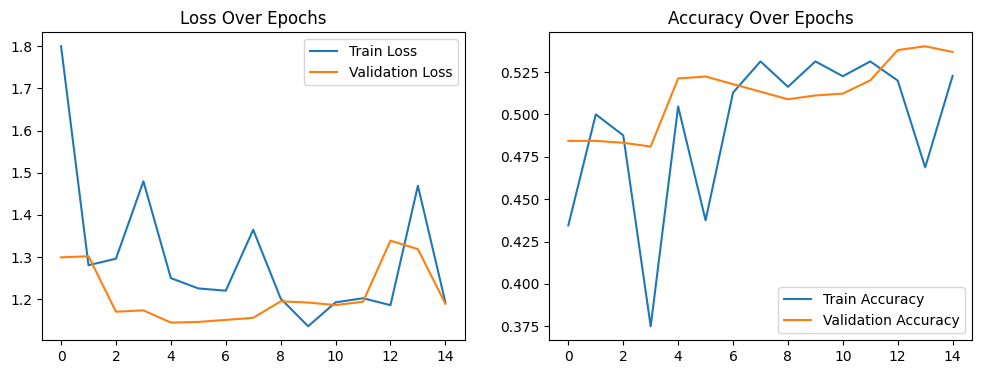

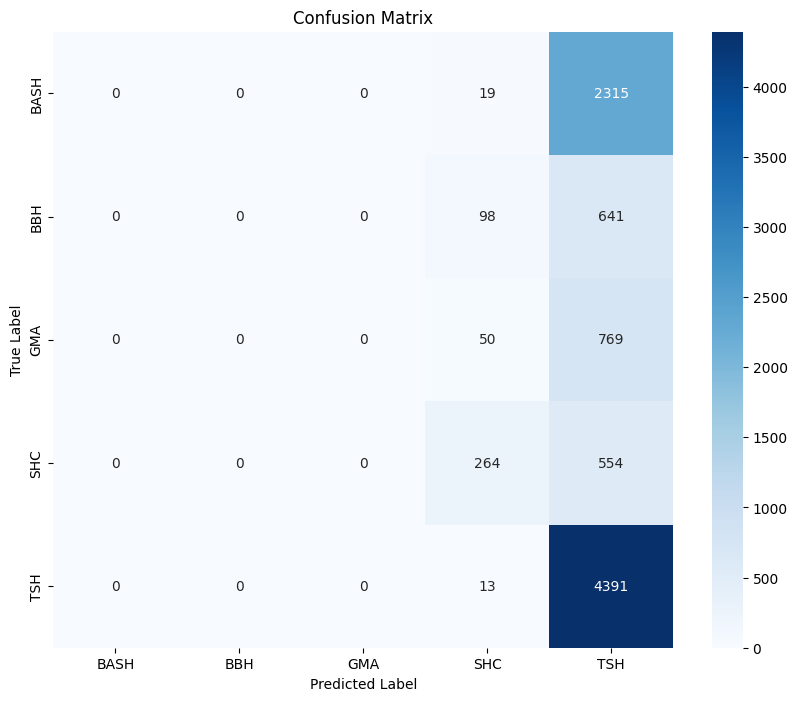

In [69]:
# Curvas de aprendizado
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.show()

# Matriz de confusão com nomes corretos
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
